# **Melanoma Detection Model by building a multiclass classification model using a custom convolutional neural network in TensorFlow.**

---



#Problem statement:

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

#About Dataset:

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.


*The data set contains the following diseases:*

- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion

#Goal:

 To create a multiclass classification model using a custom convolutional neural network in tensorflow

#Approach of Model training
    
**We are going to follow the below steps throughout this model building and training process i.e. :**
- Data Reading/Data Understanding
- Dataset Creation
- Dataset visualisation
- Model Building & training
- Chose an appropriate data augmentation strategy to resolve underfitting/overfitting and then Model Building & training on the augmented data
- Understanding class distribution
- Handling class imbalances and Model Building & training on the rectified class imbalance data

## *`Step 1: Data Reading/Data Understanding`*

**Importing all the important libraries**

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
import zipfile
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img


**Importing dataset**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Specifying the path to my zip file
zip_path = "/content/gdrive/MyDrive/CNN_assignment_collab.zip"

# Specifying the destination directory to extract the files
extract_path = "/content/extracted_dataset"

# Extracting the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [4]:
# Defining the path for train and test images
root_path = '/content/extracted_dataset/CNN_assignment_collab'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [5]:
# Peeping a glimpse of the image counts
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(f"Training dataset count: {image_count_train}")
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(f"Testing dataset count: {image_count_test}")

Training dataset count: 2239
Testing dataset count: 118


## *`Step 2: Dataset Creation`*

Now we will load the images using keras.preprocessing library with image_dataset_from_directory utility

In [6]:
#defining some parameters for the loaders
batch_size = 32
img_height = 180
img_width = 180

**using 80-20 ration for training and validation datasets**

In [7]:
# training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
# validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


**We will now list all the classes of the dataset(i.e. of skin cancer)**

In [10]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## *`Step 3: Dataset Visualization`*

In [11]:
def visualize_class(data_dir_train,class_names):
  #Dictionary to store the path of image as per the class
  files_path_dict = {}

  for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

  # plotting the images to visualize one instance of all the classes of dataset
  plt.figure(figsize=(10,10))
  index = 0
  for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

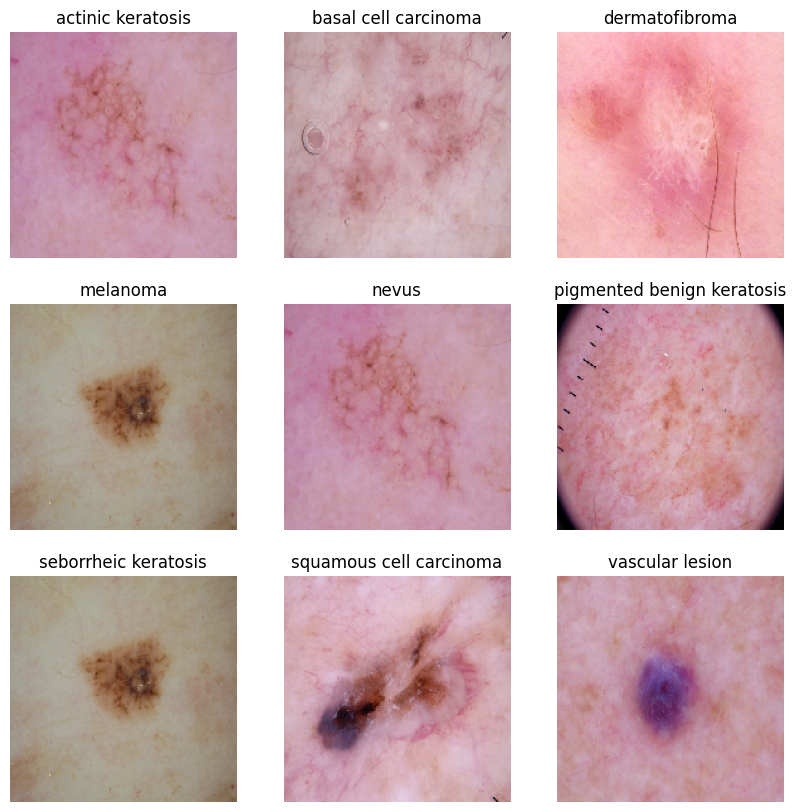

In [12]:
visualize_class(data_dir_train,class_names)

We will use **`Dataset.cache()`** and **`Dataset.prefetch()`** which keeps the images in memory after they're loaded off disk during the first epoch
and overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## *`Step 4: Model building and training`*

**To create a CNN model, which can accurately detect 9 classes present in the dataset, we will use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range.
Here, while building the model, we are rescaling images to normalize pixel values between (0,1)**

In [14]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

**CNN model architecture - `MODEL-1`**

In [15]:
input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model1 = Sequential()
model1.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model1.add(MaxPool2D(pool_size=(2, 2)))

model1.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPool2D(pool_size=(2, 2)))

model1.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPool2D(pool_size=(2, 2)))

model1.add(Flatten())

model1.add(Dense(512, activation='relu'))
model1.add(Activation('relu'))
model1.add(Dropout(0.5))
model1.add(Dense(1))
model1.add(Activation('sigmoid'))


**Compiling the model-1**

In [16]:
# taking optimizer as adam and loss function as binary crossentropy for compiling the model
optimizer = 'adam'
loss_fn = "binary_crossentropy"
model1.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [17]:
## Model 1 summary
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrapp  (None, 178, 178, 32)     896       
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 176, 176, 32)     9248      
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 88, 88, 32)       0         
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 86, 86, 64)       18496     
 pper)                                                  

**Training the model-1**

In [18]:
# Taking epoch size as 20, and batch size as 32
epochs = 20

history = model1.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 28s 148ms/step - loss: -72056.3906 - accuracy: 0.1696 - val_loss: -59463.0430 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 4s 63ms/step - loss: -818293.8750 - accuracy: 0.1724 - val_loss: -742004.8125 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 4s 63ms/step - loss: -3099564.7500 - accuracy: 0.1724 - val_loss: -3503192.2500 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - 4s 66ms/step - loss: -7742796.5000 - accuracy: 0.1724 - val_loss: -9985819.0000 - val_accuracy: 0.1499
Epoch 5/20
56/56 [==============================] - 4s 63ms/step - loss: -15468032.0000 - accuracy: 0.1724 - val_loss: -18779338.0000 - val_accuracy: 0.1499
Epoch 6/20
56/56 [==============================] - 4s 63ms/step - loss: -26993010.0000 - accuracy: 0.1724 - val_loss: -29372508.0000 - val_accuracy: 0.1499
Epoch 7/20
56/56 [==============================] - 4s 65ms/step - los

**Visualizing training results**

In [19]:
# function to plot training and validation accuracy & loss
def plot_accuracy_loss(epoch):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

# function to evaluate model ,and print accuracy and loss
def eval_model(train_ds,val_ds,model):
  loss, accuracy = model.evaluate(train_ds, verbose=1,)
  loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

  print("Accuracy: ", accuracy)
  print("Validation Accuracy: ",accuracy_v)
  print("Loss: ",loss)
  print("Validation Loss", loss_v)


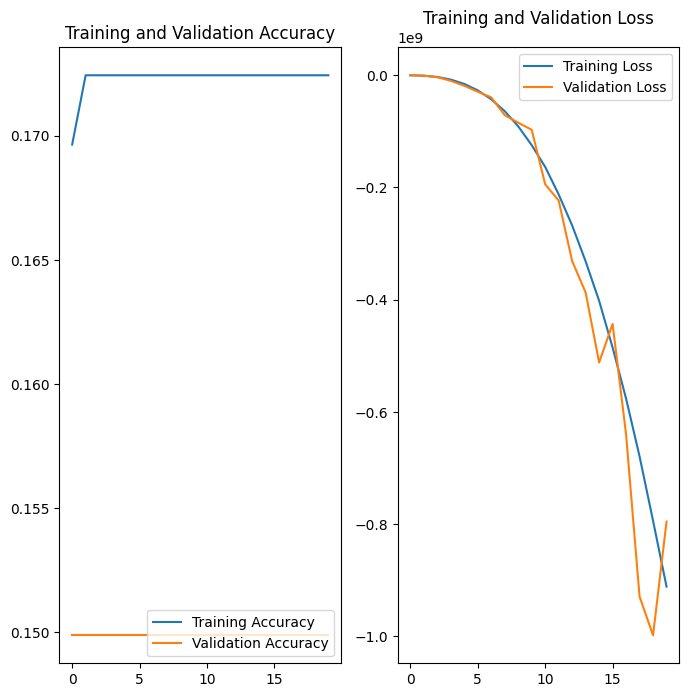

In [21]:
plot_accuracy_loss(epochs)

In [22]:
eval_model(train_ds,val_ds,model1)

14/14 [==============================] - 0s 18ms/step - loss: -795515648.0000 - accuracy: 0.1499
Accuracy:  0.1724330335855484
Validation Accuracy:  0.14988814294338226
Loss:  -775018304.0
Validation Loss -795515648.0


In [23]:
def model_predict(model):
  Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
  Test_image = glob(Test_image_path)
  Test_image = load_img(Test_image[-1],target_size=(180,180,3))
  plt.imshow(Test_image)
  plt.grid(False)

  img = np.expand_dims(Test_image,axis=0)
  pred = model.predict(img)
  pred = np.argmax(pred)
  pred_class = class_names[pred]
  print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )

1/1 [==============================] - 0s 337ms/step
Actual Class basal cell carcinoma
Predictive Class actinic keratosis


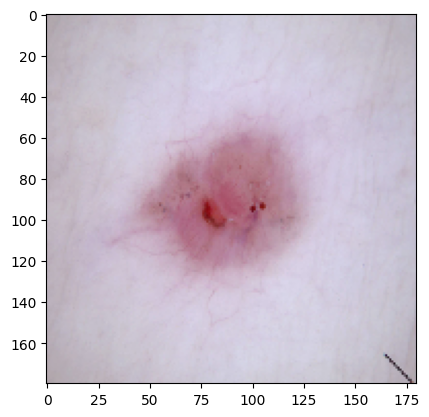

In [24]:
model_predict(model1)

>**Insights:** We can clearly see that model overfit and we need to chose right data augumentation strategy

## *`Step 5: Chose an appropriate data augmentation strategy to resolve underfitting/overfitting and then Model Building & training on the augmented data`*

First we are using ImageDataGenerator, which will allow our model to receive new variations of the images at each epoch. We can set many variations such as whitening, zoom ranges, height shift etc to make the variations in the dataset.

In [25]:
# creating new data generated, by using ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

# creating training batches with the new datagen
train_batches = datagen.flow_from_directory(data_dir_train,
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

# creating validation batches with the new datagen
valid_batches = datagen.flow_from_directory(data_dir_test,
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)


Found 890 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


**Visualizing how our augmentation strategy works for one instance of training image.**

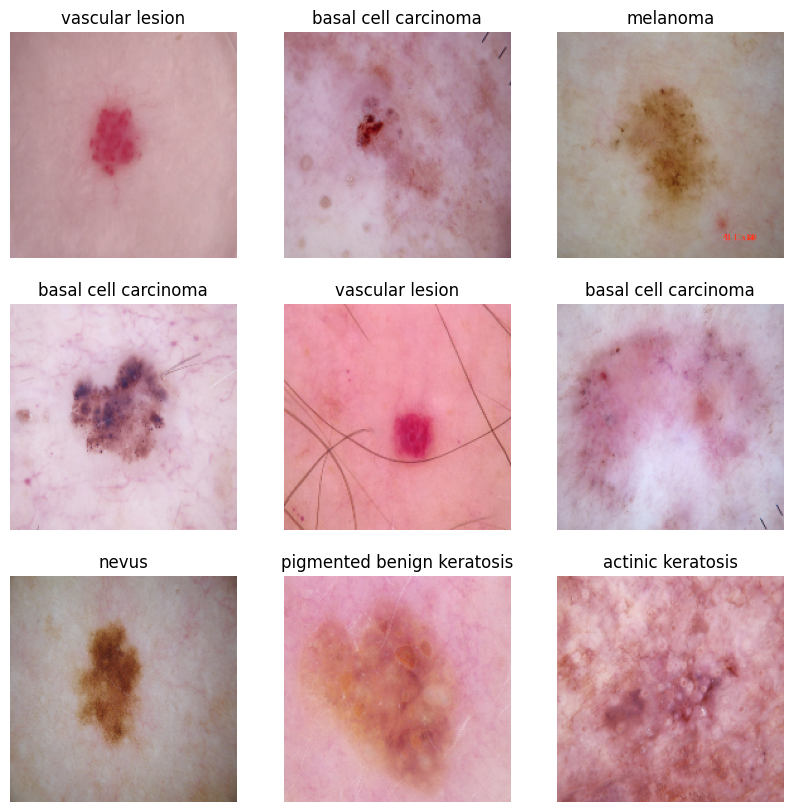

In [26]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

 **Creating the model-2**

In [27]:
model2 = Sequential()

# Increasing the model size by adding another 32 layer
model2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
# Max Pool size of 2*2
model2.add(MaxPool2D(pool_size=(2, 2)))
# Adding Dropout Layer
model2.add(Dropout(0.25))

model2.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model2.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(0.4))

model2.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(0.4))

model2.add(Flatten())

model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(9, activation='softmax'))


**Compiling the model-2**

In [28]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model2.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

We are using an annealing method of the learning rate (LR), which will make the optimizer converge faster and closest to the global minimum of the loss function

In [29]:
# Setting a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001)

**Training the model-2**

In [30]:
epochs = 20
batch_size = 10
history = model2.fit(train_batches,
  epochs = epochs, verbose = 1, validation_data=valid_batches , callbacks=[learning_rate_reduction])

Epoch 1/20
14/14 [==============================] - 49s 3s/step - loss: 284.5320 - accuracy: 0.3888 - val_loss: 2.0619 - val_accuracy: 0.3542 - lr: 0.0010
Epoch 2/20
14/14 [==============================] - 47s 3s/step - loss: 1.8776 - accuracy: 0.4382 - val_loss: 2.1448 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/20
14/14 [==============================] - 37s 3s/step - loss: 1.3329 - accuracy: 0.4483 - val_loss: 2.0874 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 4/20
14/14 [==============================] - ETA: 0s - loss: 1.1714 - accuracy: 0.4573
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
14/14 [==============================] - 39s 3s/step - loss: 1.1714 - accuracy: 0.4573 - val_loss: 2.0535 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 5/20
14/14 [==============================] - 36s 3s/step - loss: 1.0385 - accuracy: 0.4921 - val_loss: 2.0425 - val_accuracy: 0.3333 - lr: 5.0000e-04
Epoch 6/20
14/14 [==============================] - 36s 3s/step - loss

**Visualizing the results**

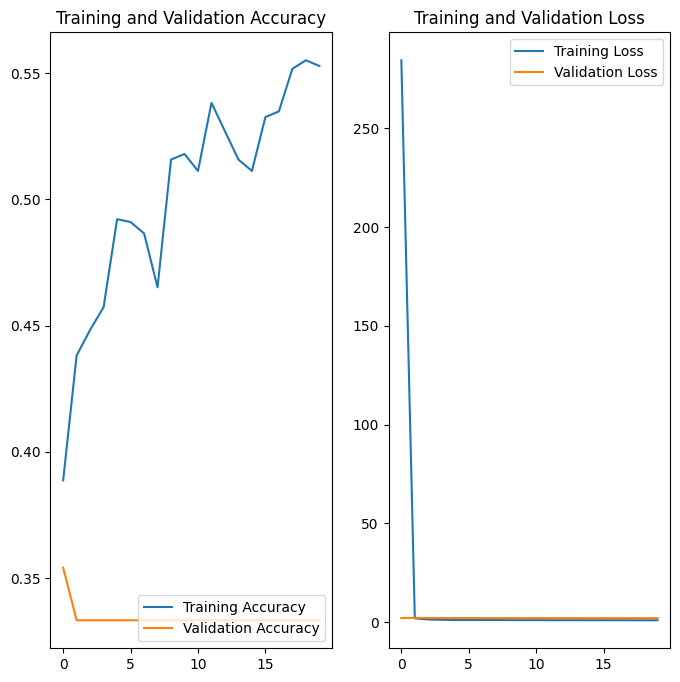

In [31]:
plot_accuracy_loss(epochs)

In [32]:
eval_model(train_batches,valid_batches,model2)

1/1 [==============================] - 5s 5s/step - loss: 2.0063 - accuracy: 0.3333
Accuracy:  0.401123583316803
Validation Accuracy:  0.3333333432674408
Loss:  1.949903130531311
Validation Loss 2.0063493251800537


1/1 [==============================] - 0s 301ms/step
Actual Class basal cell carcinoma
Predictive Class actinic keratosis


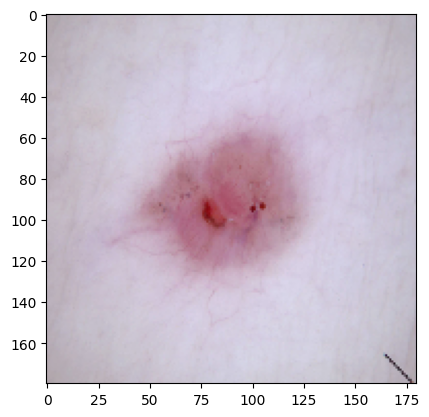

In [33]:
model_predict(model2)

>**Insights:** In the earlier case of model-1, we have seen that there was a mkajor overfitting case. In the model-2 scenario, we can see it is getting better

## *`Step 6: Understanding class distribution`*

**Finding the distribution of classes in the training set**

In [34]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,pigmented benign keratosis,462
1,basal cell carcinoma,376
2,melanoma,438
3,nevus,357
4,dermatofibroma,95
5,actinic keratosis,114
6,seborrheic keratosis,77
7,vascular lesion,139
8,squamous cell carcinoma,181


<Axes: xlabel='No. of Image', ylabel='Class'>

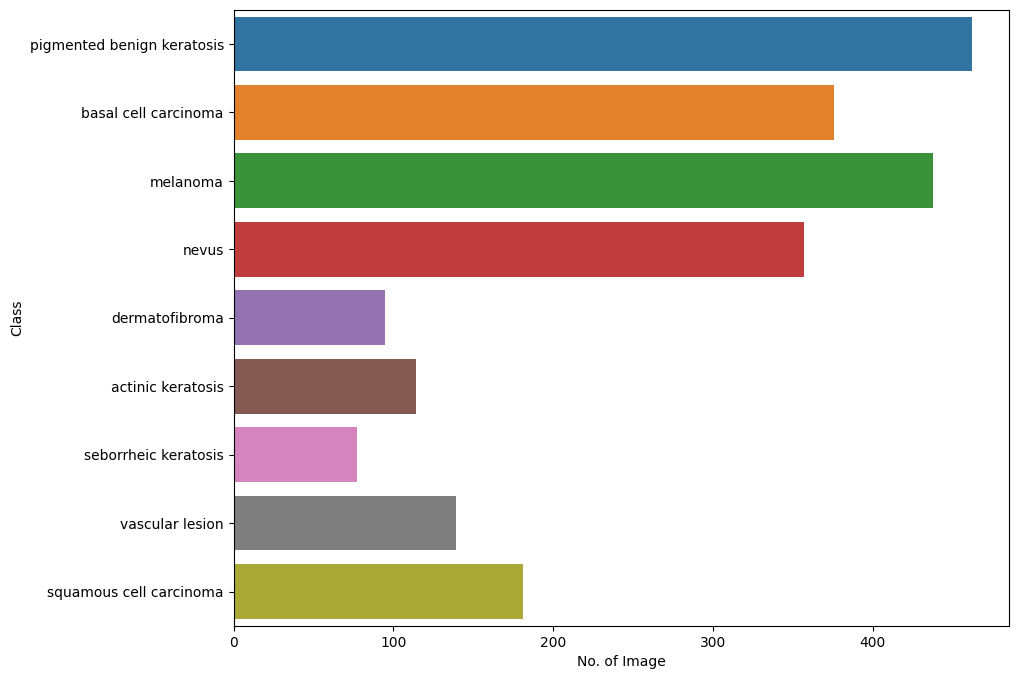

In [35]:
#Visualizing the number of image in each class.

plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

>**Insights:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.
>
> *Which class has the least number of samples?*
>- **Dermatofibroma** and **Seborrheic keratosis**
>
> *Which classes dominate the data in terms proportionate number of samples?*
>- **Pigmented benign keratosis** dominates the data of count more than 100 in training

## *`Step 7: Handling class imbalances and Model Building & training on the rectified class imbalance data`*

**Now to rectify the class imbalance, we will use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.**

In [36]:
!pip install Augmentor

**To use `Augmentor`, the following general procedure is followed:**

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [37]:
training_dataset="/content/extracted_dataset/CNN_assignment_collab/Train"

import Augmentor
for i in class_names:
    print(training_dataset + "/" +  i)
    p = Augmentor.Pipeline(training_dataset + "/" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.crop_random(probability=0.8,percentage_area=0.3,randomise_percentage_area=True)
    p.flip_top_bottom(probability=0.5)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

/content/extracted_dataset/CNN_assignment_collab/Train/actinic keratosis
Initialised with 114 image(s) found.
Output directory set to /content/extracted_dataset/CNN_assignment_collab/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6F0CE50280>: 100%|██████████| 500/500 [00:19<00:00, 25.31 Samples/s]


/content/extracted_dataset/CNN_assignment_collab/Train/basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to /content/extracted_dataset/CNN_assignment_collab/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=102x76 at 0x7F6F0CDF65C0>: 100%|██████████| 500/500 [00:23<00:00, 21.52 Samples/s]


/content/extracted_dataset/CNN_assignment_collab/Train/dermatofibroma
Initialised with 95 image(s) found.
Output directory set to /content/extracted_dataset/CNN_assignment_collab/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=120x90 at 0x7F6F0CDCFD30>: 100%|██████████| 500/500 [00:22<00:00, 22.70 Samples/s]


/content/extracted_dataset/CNN_assignment_collab/Train/melanoma
Initialised with 438 image(s) found.
Output directory set to /content/extracted_dataset/CNN_assignment_collab/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=399x299 at 0x7F6F0CE52860>: 100%|██████████| 500/500 [01:35<00:00,  5.25 Samples/s]


/content/extracted_dataset/CNN_assignment_collab/Train/nevus
Initialised with 357 image(s) found.
Output directory set to /content/extracted_dataset/CNN_assignment_collab/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6F00F4B5B0>: 100%|██████████| 500/500 [01:13<00:00,  6.80 Samples/s]


/content/extracted_dataset/CNN_assignment_collab/Train/pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to /content/extracted_dataset/CNN_assignment_collab/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=156x117 at 0x7F6F20500CA0>: 100%|██████████| 500/500 [00:16<00:00, 29.88 Samples/s]


/content/extracted_dataset/CNN_assignment_collab/Train/seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to /content/extracted_dataset/CNN_assignment_collab/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=215x161 at 0x7F6FA80D4640>: 100%|██████████| 500/500 [00:40<00:00, 12.41 Samples/s]


/content/extracted_dataset/CNN_assignment_collab/Train/squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to /content/extracted_dataset/CNN_assignment_collab/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=174x130 at 0x7F6FAB8DB010>: 100%|██████████| 500/500 [00:16<00:00, 30.80 Samples/s]


/content/extracted_dataset/CNN_assignment_collab/Train/vascular lesion
Initialised with 139 image(s) found.
Output directory set to /content/extracted_dataset/CNN_assignment_collab/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=138x103 at 0x7F6FA8ADE0E0>: 100%|██████████| 500/500 [00:17<00:00, 29.37 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.Lets take a look at total count of augmented images.

In [38]:
count_image_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(count_image_train)

4500


**Lets see the distribution of augmented data after adding new images to the original training data.**

In [39]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [40]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

#counting the distribution of images in classes, after augmenting the data
new_df['Label'].value_counts()

pigmented benign keratosis    500
basal cell carcinoma          500
melanoma                      500
nevus                         500
dermatofibroma                500
actinic keratosis             500
seborrheic keratosis          500
vascular lesion               500
squamous cell carcinoma       500
Name: Label, dtype: int64

**Creating the dataset for the model-3, created using Augmentor**

In [41]:
# creating training data set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [42]:
# creating validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


**Creating the model-3**

In [43]:
model3 = Sequential()

# Increse the model size by adding another 32 layer
model3.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model3.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))

# Max Pool size of 2*2
model3.add(MaxPool2D(pool_size=(2, 2)))
model3.add(BatchNormalization())
# Adding Dropout Layer
model3.add(Dropout(0.25))

model3.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model3.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model3.add(MaxPool2D(pool_size=(2, 2)))
model3.add(BatchNormalization())
model3.add(Dropout(0.35))

model3.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2, 2)))
model3.add(Dropout(0.4))

model3.add(Flatten())

model3.add(Dense(128, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))
model3.add(Dense(1, activation='softmax'))


**Compiling model-3**

In [44]:
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model3.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

**Training model-3**

In [45]:
epochs = 30

reduced_learning_rate = ReduceLROnPlateau(monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001)

history = model3.fit(train_ds,
  epochs = epochs, verbose = 1, validation_data=val_ds , callbacks=[reduced_learning_rate])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


540/540 [==============================] - 33s 56ms/step - loss: 0.0000e+00 - accuracy: 0.1337 - val_loss: 0.0000e+00 - val_accuracy: 0.1151 - lr: 1.0000e-04
Epoch 2/30
540/540 [==============================] - 29s 53ms/step - loss: 0.0000e+00 - accuracy: 0.1337 - val_loss: 0.0000e+00 - val_accuracy: 0.1151 - lr: 1.0000e-04
Epoch 3/30
540/540 [==============================] - 31s 56ms/step - loss: 0.0000e+00 - accuracy: 0.1337 - val_loss: 0.0000e+00 - val_accuracy: 0.1151 - lr: 1.0000e-04
Epoch 4/30
539/540 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.1338
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
540/540 [==============================] - 30s 54ms/step - loss: 0.0000e+00 - accuracy: 0.1337 - val_loss: 0.0000e+00 - val_accuracy: 0.1151 - lr: 1.0000e-04
Epoch 5/30
540/540 [==============================] - 29s 53ms/step - loss: 0.0000e+00 - accuracy: 0.1337 - val_loss: 0.0000e+00 - val_accuracy: 0.1151 - lr: 5.0000e-05
E

In [46]:
#model summary
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper_28 (ModuleWr  (None, 180, 180, 32)     896       
 apper)                                                          
                                                                 
 module_wrapper_29 (ModuleWr  (None, 180, 180, 32)     9248      
 apper)                                                          
                                                                 
 module_wrapper_30 (ModuleWr  (None, 90, 90, 32)       0         
 apper)                                                          
                                                                 
 batch_normalization_2 (Batc  (None, 90, 90, 32)       128       
 hNormalization)                                                 
                                                                 
 module_wrapper_31 (ModuleWr  (None, 90, 90, 32)      

**Visualize model-3 result**

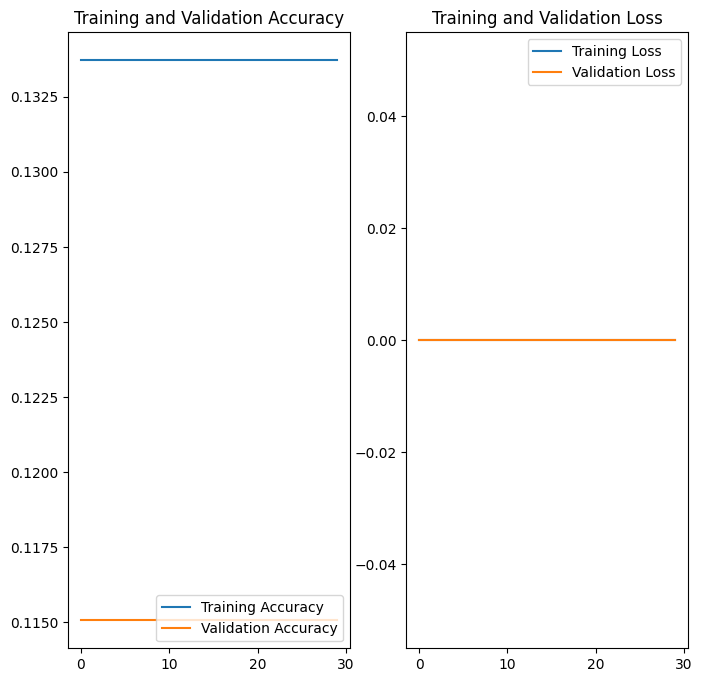

In [47]:
plot_accuracy_loss(epochs)

In [48]:
eval_model(train_ds,val_ds,model3)

135/135 [==============================] - 4s 30ms/step - loss: 0.0000e+00 - accuracy: 0.1151
Accuracy:  0.1337166130542755
Validation Accuracy:  0.11507052928209305
Loss:  0.0
Validation Loss 0.0


1/1 [==============================] - 0s 200ms/step
Actual Class basal cell carcinoma
Predictive Class actinic keratosis


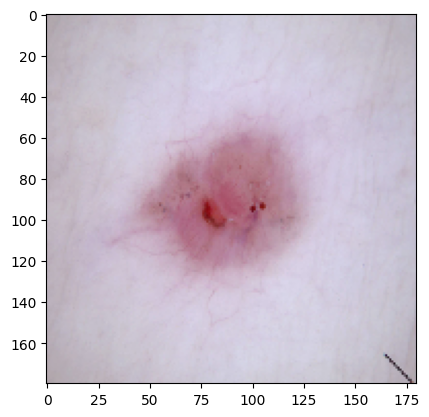

In [49]:
model_predict(model3)

>**Insights**
>
>- Model 1 using a simple dataset has low accuracy and validation accuracy, indicating poor performance. The negative loss values suggest a problem with the loss calculation.
>
>- Model 2 using Imagedatagenerator shows improved accuracy and validation accuracy. The loss values are positive and within a reasonable range, indicating better training and validation performance.
>
>- Model 3 using augmentor has the lowest accuracy and validation accuracy, indicating poor performance. The loss values of 0.0 suggest that the model did not learn effectively or failed to converge.
>
>- Model 2 using Imagedatagenerator demonstrates the best performance with higher accuracy and reasonable loss values compared to the other models.